In [6]:
%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
from cargo_centerline_extraction_test import load_point_cloud
from cargo_centerline_extraction_test import ws_path
from pathlib import Path
import os,sys
import matplotlib

print("Python version:", sys.version)
print("Matplotlib version:", matplotlib.__version__)
print("Backend:", matplotlib.get_backend())
print("ipympl installed:", 'ipympl' in sys.modules)

# points = load_point_cloud(ws_path + "/data/cargo_box.pcd")
points = load_point_cloud(ws_path + "/data/large_cargo2.pcd")


Python version: 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:29:10) [GCC 14.3.0]
Matplotlib version: 3.10.6
Backend: widget
ipympl installed: True
Loaded 16000 points from /opt/tong/ws/git_repo/CargoCenterline3D/data/large_cargo2.pcd


## detect_plane_open3d

In [7]:
import site
site.addsitedir(ws_path+'/src')

from cargo_centerline_extraction import detect_plane_open3d

plane_equation, inlier_indices = detect_plane_open3d(points=points)

## project_points_to_plane

In [8]:

from cargo_centerline_extraction import project_points_to_plane

project_points = project_points_to_plane(points=points,plane_equation=plane_equation)

## compute_centerline

In [9]:
from cargo_centerline_extraction import compute_centerline

centerline, left_points, right_points = compute_centerline(projected_points=project_points)

## 创建 plt

Detected plane equation: 0.0001x + -0.0007y + 1.0000z + 0.0016 = 0


(-0.5, 1.5)

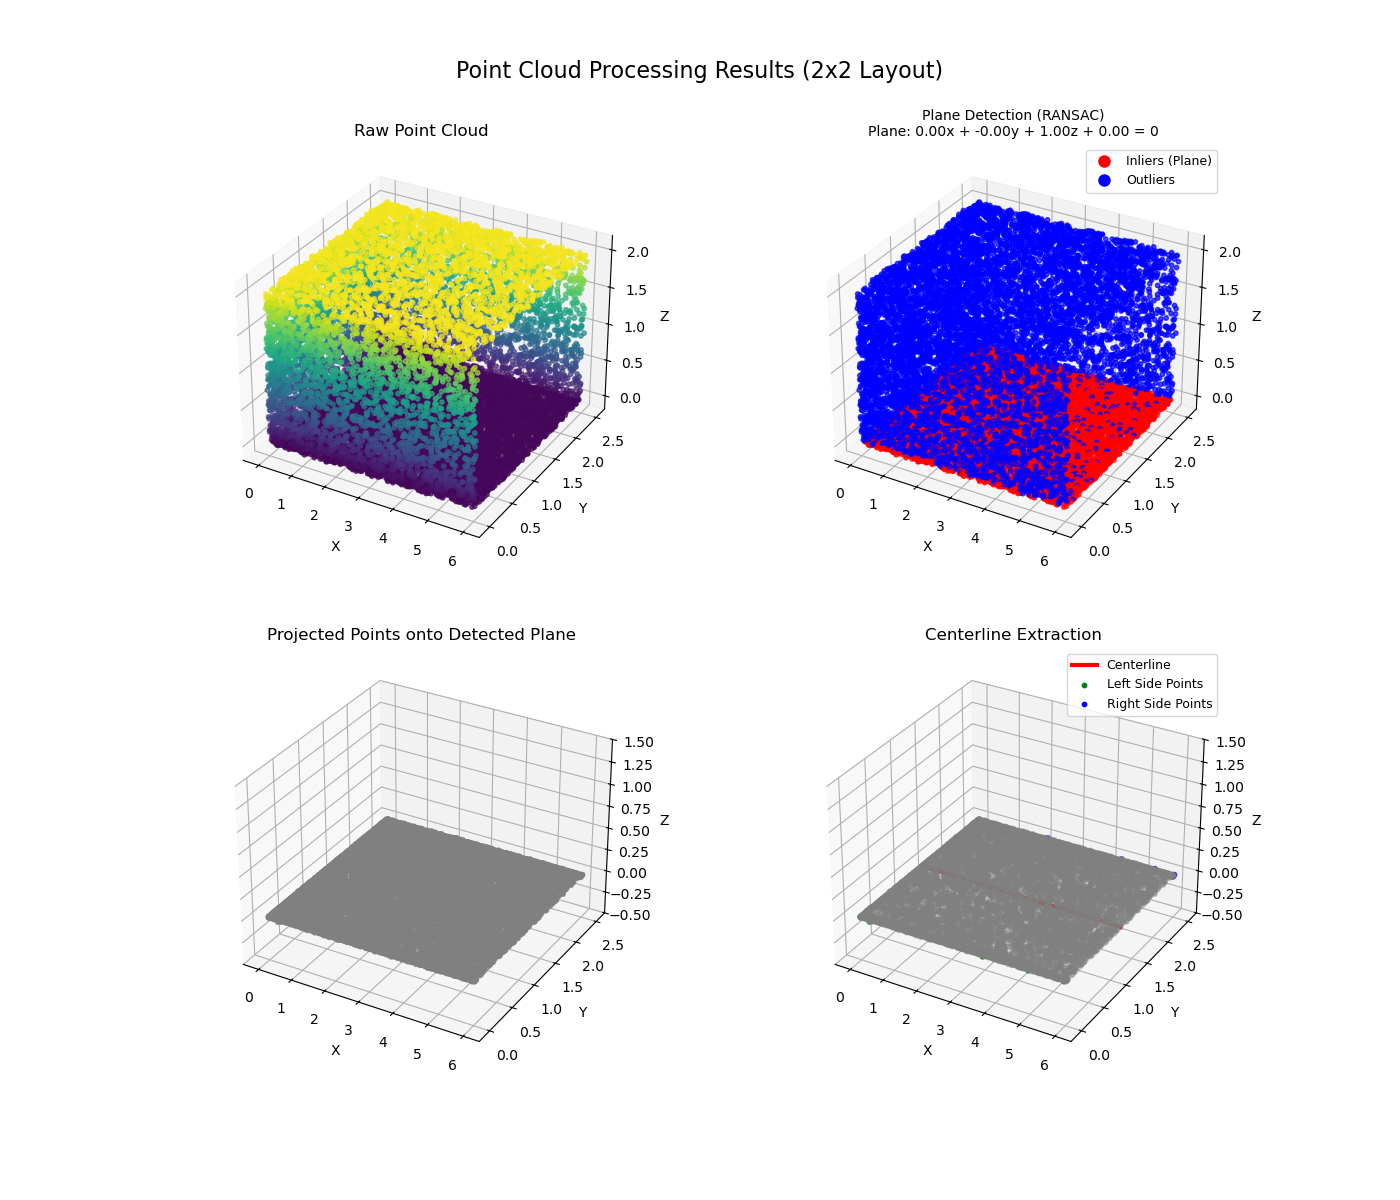

In [10]:

from cargo_centerline_extraction_test import plot_point_cloud

fig = plt.figure(figsize=(14, 12))

# 创建四个3D子图
ax1 = fig.add_subplot(2, 2, 1, projection="3d")
ax2 = fig.add_subplot(2, 2, 2, projection="3d")
ax3 = fig.add_subplot(2, 2, 3, projection="3d")
ax4 = fig.add_subplot(2, 2, 4, projection="3d")

### ax1: Raw Point Cloud
scatter1 = plot_point_cloud(ax1, points, "Raw Point Cloud", "viridis")

# Add main title
fig.suptitle("Point Cloud Processing Results (2x2 Layout)", fontsize=16, y=0.95)
# 添加统一的颜色条
# cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
# cbar = fig.colorbar(scatter1, cax=cbar_ax)
# cbar.set_label("Z value", fontsize=12)

### ax2: Plane Detection Results
# Plot plane detection results
if inlier_indices is not None:
    # Create color array: red for inliers, blue for outliers
    colors = np.zeros((len(points), 3))  # RGB array
    colors[inlier_indices] = [1, 0, 0]  # Red for inliers
    colors[~np.isin(np.arange(len(points)), inlier_indices)] = [0, 0, 1]  # Blue for outliers

    # Plot with color-coded inliers/outliers
    scatter2 = plot_point_cloud(ax2, points, "Plane Detection (RANSAC)", colors=colors)
    print(f"Detected plane equation: {plane_equation[0]:.4f}x + {plane_equation[1]:.4f}y + " f"{plane_equation[2]:.4f}z + {plane_equation[3]:.4f} = 0")

    # Add plane equation to title
    if plane_equation is not None:
        a, b, c, d = plane_equation
        ax2.set_title(f"Plane Detection (RANSAC)\nPlane: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0", fontsize=10)
else:
    # Fallback if plane detection failed
    scatter2 = plot_point_cloud(ax2, points, "Plane Detection Failed", "viridis")

if inlier_indices is not None:
    from matplotlib.lines import Line2D

    legend_elements = [
        Line2D([0], [0], marker="o", color="w", label="Inliers (Plane)", markerfacecolor="red", markersize=10),
        Line2D([0], [0], marker="o", color="w", label="Outliers", markerfacecolor="blue", markersize=10),
    ]
    ax2.legend(handles=legend_elements, loc="upper right", fontsize=9)


### ax3: Projected Points onto Detected Plane
scatter3 = plot_point_cloud(ax3, project_points, "Projected Points onto Detected Plane", colors="gray")
ax3.set_zlim(-0.5, 1.5)

### ax4: Centerline Extraction Results
scatter4 = plot_point_cloud(ax4, project_points, "Centerline Extraction", colors="gray")
scatter4.set_alpha(0.3)
# Overlay centerline
ax4.plot(centerline[:, 0], centerline[:, 1], centerline[:, 2], color="red", linewidth=3, label="Centerline")
ax4.scatter(left_points[:, 0], left_points[:, 1], left_points[:, 2], color="green", s=10, label="Left Side Points")
ax4.scatter(right_points[:, 0], right_points[:, 1], right_points[:, 2], color="blue", s=10, label="Right Side Points")
ax4.legend(loc="upper right", fontsize=9)
ax4.set_zlim(-0.5, 1.5)


# fig.show()
# fig.savefig("CenterlineExtraction.png")


## end